Dev notes: I directly installed the model en_core_web_sm 3.7.1 via 'uv add'.

In [5]:
from torchtext import data, datasets
import torch
import spacy
import random

# Load SpaCy
nlp = spacy.load("en_core_web_sm")

 # For tokenization
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm',include_lengths = True)
# For multi - class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data , test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained = False)
# Split train into train/valid (80/20)
train_data, valid_data = train_data.split(
    split_ratio=0.8,
    random_state=random.seed(42)  # <-- use random.seed here
)

print(f"Train examples: {len(train_data)}")
print(f"Validation examples: {len(valid_data)}")

Train examples: 4362
Validation examples: 1090


In [6]:
print(vars(train_data.examples[0]))

{'text': ['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?'], 'label': 'ENTY'}


Let's use Glove model for word embeddings.     
(Start with GloVe 6B.100d or 6B.300d as it provides a good balance between coverage and performance for TREC's question classification task. If results are underwhelming, experiment with word2vec Google News vectors as an alternative, but empirical results in the literature suggest GloVe performs comparably or slightly better on this specific dataset.)

In [7]:
from torchtext.vocab import GloVe, Vectors

# Option 1: Use built-in GloVe (torchtext will download automatically)
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=100))

In [8]:
LABEL.build_vocab(train_data)

# Qn 1: Word Embeddings
a) What is the size of the vocabulary formed from your training data according to your tokenization method?

In [9]:
# Get vocabulary size
vocab_size = len(TEXT.vocab)
print(f"Vocabulary size: {vocab_size}")
print("# of Labels: ", len(LABEL.vocab))  # number of distinct labels (topics)

Vocabulary size: 8093
# of Labels:  6


b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but
not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?
What is the number of OOV words for each topic category?

In [10]:
import torchtext
from collections import defaultdict, Counter
# Get only the GloVe vocab (words with pretrained vectors)
glove_vocab = set(torchtext.vocab.GloVe(name='6B', dim=100).stoi.keys())

oov_words_by_topic = defaultdict(Counter)

for example in train_data.examples:
    label = example.label
    tokens = example.text  # Already tokenized as list of tokens by spacy
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower not in glove_vocab:
            oov_words_by_topic[label][token_lower] += 1

total_oov_words = set()
for counter in oov_words_by_topic.values():
    total_oov_words.update(counter.keys())

total_count = sum(
    count
    for counter in oov_words_by_topic.values()
    for count in counter.values()
)
print(f"Total count of all OOV word occurrences: {total_count}")
print(f"Total number of OOV words in training data: {len(total_oov_words)}")
print("Number of OOV words per topic category:")

for topic, counter in oov_words_by_topic.items():
    print(f"Topic {topic}: {len(counter)} unique OOV words")
    print("Total occurrence of OOV words: ", sum(counter.values()))
    print("-"*50)


Total count of all OOV word occurrences: 202
Total number of OOV words in training data: 190
Number of OOV words per topic category:
Topic DESC: 68 unique OOV words
Total occurrence of OOV words:  69
--------------------------------------------------
Topic ENTY: 47 unique OOV words
Total occurrence of OOV words:  52
--------------------------------------------------
Topic HUM: 39 unique OOV words
Total occurrence of OOV words:  40
--------------------------------------------------
Topic ABBR: 4 unique OOV words
Total occurrence of OOV words:  4
--------------------------------------------------
Topic NUM: 21 unique OOV words
Total occurrence of OOV words:  21
--------------------------------------------------
Topic LOC: 15 unique OOV words
Total occurrence of OOV words:  16
--------------------------------------------------


(c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
think is the best strategy to mitigate such limitation? Implement your solution in your source
code. Show the corresponding code snippet

One way to mitigate the problem of OOV words is to replace them with  \<unk\>.

In [11]:
def replace_oov_with_unk(tokens, glove_vocab):
    return [token if token.lower() in glove_vocab else '<unk>' for token in tokens]

for example in train_data.examples:
    tokens = example.text
    example.text = replace_oov_with_unk(tokens, glove_vocab)


Double check that the number of \<unk\> replaced the same number of OOV words.

In [12]:
unk_count = 0
for example in train_data.examples:
    label = example.label
    tokens = example.text
    for token in tokens:
        # Lowercase token to match GloVe casing
        token_lower = token.lower()
        if token_lower == "<unk>":
            unk_count += 1
unk_count

202

d) Select the 20 most frequent words from each topic category in the training set (removing
stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
Analyze your findings

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asherlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


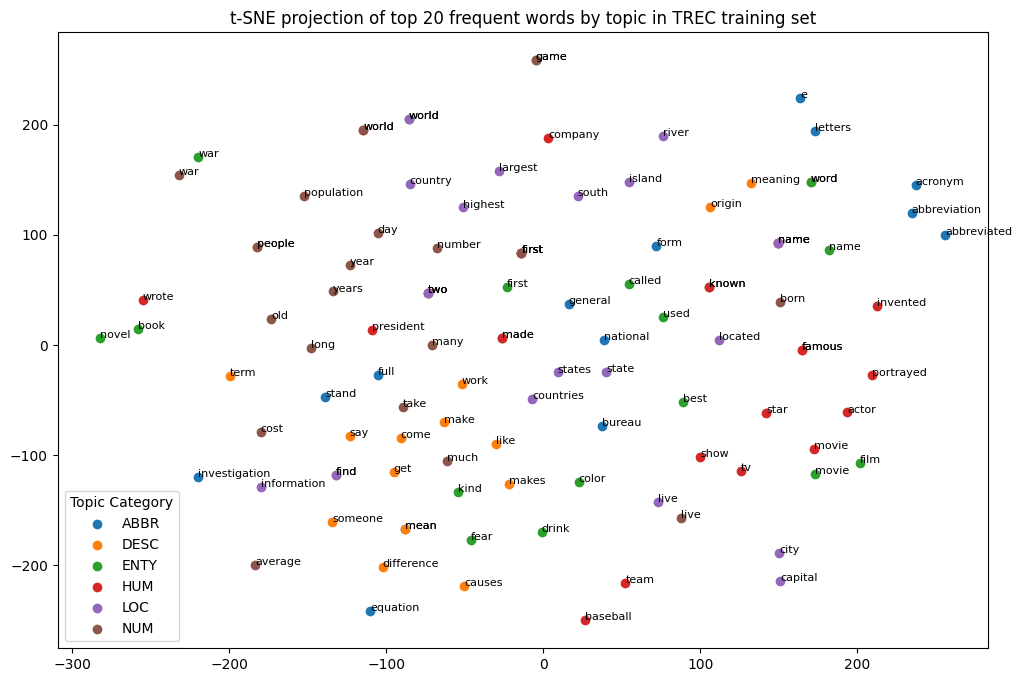

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
from nltk.corpus import stopwords
import nltk
import torchtext

# Download stopwords if needed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Collect tokens by topic, remove stopwords, non-alpha tokens
tokens_by_topic = defaultdict(list)
for example in train_data.examples:
    label = example.label
    tokens = example.text
    filtered_tokens = [t.lower() for t in tokens if t.isalpha() and t.lower() not in stop_words]
    tokens_by_topic[label].extend(filtered_tokens)

# Select top 20 frequent words by topic
top_words_by_topic = {}
for topic, tokens in tokens_by_topic.items():
    counter = Counter(tokens)
    top_words_by_topic[topic] = [w for w, _ in counter.most_common(20)]

# Retrieve pretrained embeddings for these words
vectors = TEXT.vocab.vectors
vocab_stoi = TEXT.vocab.stoi

word_vectors = []
labels_for_words = []
words_flat = []

for topic, words in top_words_by_topic.items():
    for word in words:
        idx = vocab_stoi.get(word, -1)
        if idx >= 0:
            vec = vectors[idx].numpy()
            word_vectors.append(vec)
            labels_for_words.append(topic)
            words_flat.append(word)

word_vectors = np.array(word_vectors)

# t-SNE projection to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(word_vectors)

# Plot scatter plot color-coded by topics
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10.colors
unique_topics = sorted(top_words_by_topic.keys())
color_dict = {topic: colors[i % 10] for i, topic in enumerate(unique_topics)}

for topic in unique_topics:
    indices = [i for i, t in enumerate(labels_for_words) if t == topic]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                c=[color_dict[topic]], label=topic)

for i, word in enumerate(words_flat):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(title='Topic Category')
plt.title('t-SNE projection of top 20 frequent words by topic in TREC training set')
plt.show()

# Analysis
Distinct Topic Clusters: Some topic categories (like “LOC” for locations and “HUM” for human/person entities) show partial clustering, indicating that frequent words in these topics are semantically related in the embedding space.

Overlap Between Topics: There is overlap between certain categories, especially between “NUM” (numerical entities), “DESC” (descriptive), and “ENTY” (entities), revealing that these categories share common or semantically similar vocabularies (e.g., “number,” “year,” “name”).

Topic-specific Outliers: Certain words such as “baseball” (NUM), “capital” (LOC), “actor” (HUM) are positioned toward the periphery, suggesting that they have more unique, topic-centric semantic content compared to other frequent words.

Embedding Quality: The visualization demonstrates that GloVe embeddings capture topical and semantic relationships to a large extent; words with similar meanings or roles often emerge closer together regardless of label.

Ambiguity & Polysemy: Some words appear in the vicinity of different clusters or overlap areas (e.g., “mean” in DESC and NUM, “movie” in HUM and ENTY), reflecting ambiguity or multi-topic relevance.

Vocabulary Sharing Across Topics: Frequent generic words (“name,” “meaning,” “state,” “form”) are distributed among various topics, supporting the linguistically expected overlap among question categories.

Dimensionality Reduction Artifacts: t-SNE is nonlinear and can distort true distances, so while relative local clusters are meaningful, global distances should not be overinterpreted.

Label Noise: Some “outliers” may be artifacts of labeling or low sample counts; actual use in downstream classification should consider this.